In [25]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import keras
import tensorflow as tf
from tensorflow.keras import layers
from scipy import stats
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Model parameters
backwards = 4
label_period = 3
random_state = 42
test_size = 0.33

In [2]:
path = "../../../mnt/storage/Datasets/final_data/"
hip = pd.read_csv(path+"Hip.csv")
wrist = pd.read_csv(path+"Wrist.csv")
thigh = pd.read_csv(path+"Thigh.csv")
chest = pd.read_csv(path+"Chest.csv")

/home/sasthana/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (104) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
model = tf.keras.Sequential([
        layers.Dense(83, activation="relu", input_shape = (83,)),
        layers.Dense(64, activation="relu"),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(8, activation="relu"),
        layers.Dense(5, activation = 'softmax')])
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
def run_model(data):
    data.drop([col for col in data.columns if "Unnamed" in col], axis=1, inplace = True)
    # Drop un-encoded data
    data = data[data['updated_final_activity'] != 'private/not coded']

    x_cols = pd.read_csv('columns.csv')
    x_cols = x_cols['0'].to_list()
    # model inputs, standardized
    X = data[x_cols]
    X = data[x_cols].apply(lambda x: (x - np.mean(x)) / np.std(x))
    X = X.fillna(X.mean()).values
    #labels
    y = data['updated_final_activity']
    Y = pd.get_dummies(y).values
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.4, shuffle = False)
    
    model.fit(X_train, y_train,batch_size=128, epochs = 10)

    class_labels = pd.get_dummies(y).columns.tolist()
    pred = np.argmax(model.predict(X_test, verbose = 1), axis = 1)
    pred = [class_labels[x] for x in np.array(pred)]
    pred = pd.DataFrame(pred)

    y_true = np.argmax(y_test,axis =1)
    y_true = [class_labels[x] for x in np.array(y_true)]
    y_true = pd.DataFrame(y_true)
    y_true.columns = ['y_true']
    pred.columns = ['predicted_values']
    errors = pd.concat([pred,y_true], axis = 1)
    return errors
    

In [7]:
hip_pred = run_model(hip)

Epoch 1/10
204685/204685 [==============================] - 3s 13us/sample - loss: 0.6673 - acc: 0.7579
Epoch 2/10
204685/204685 [==============================] - 2s 11us/sample - loss: 0.3577 - acc: 0.8759
Epoch 3/10
204685/204685 [==============================] - 2s 11us/sample - loss: 0.3140 - acc: 0.8907
Epoch 4/10
204685/204685 [==============================] - 2s 11us/sample - loss: 0.2939 - acc: 0.8970
Epoch 5/10
204685/204685 [==============================] - 2s 11us/sample - loss: 0.2813 - acc: 0.9006
Epoch 6/10
204685/204685 [==============================] - 2s 11us/sample - loss: 0.2728 - acc: 0.9034
Epoch 7/10
204685/204685 [==============================] - 2s 11us/sample - loss: 0.2668 - acc: 0.9051
Epoch 8/10
204685/204685 [==============================] - 2s 11us/sample - loss: 0.2623 - acc: 0.9069
Epoch 9/10
204685/204685 [==============================] - 2s 11us/sample - loss: 0.2584 - acc: 0.9082
Epoch 10/10
136458/136458 [==============================] - 1s 

In [12]:
def post_process(prediction):    
    preds = prediction['predicted_values']
    preds_new = preds.copy()


    for i in range(2, len(preds)-2):
#         size = mode_size*2 +1
#         points = [None]* size
#         for j in range(size):
#             print(j)
#             print(points)
#             points[j] = preds.iloc[i - mode_size]
#             mode_size +=1
        points = [preds.iloc[i-2],preds.iloc[i-1], preds.iloc[i], preds.iloc[i+1], preds.iloc[i+2]]
        preds_new.iloc[i] = stats.mode(points)[0][0]

    preds_new = pd.DataFrame(preds_new)
    preds_new.columns = ['post_predictions']
    final_preds = pd.concat([prediction,preds_new],axis =1)

    errors_1 = final_preds['y_true'] == final_preds['predicted_values']
    errors_2 = final_preds['y_true'] == final_preds['post_predictions']

    print('predicted_value errors',np.sum(errors_1)/len(errors_1))

    print('post_processed errors',np.sum(errors_2)/len(errors_2))
    
    print('Accuracy improvement:', (np.sum(errors_2)/len(errors_2)-np.sum(errors_1)/len(errors_1)))
    return final_preds

In [15]:
monitors = [hip,wrist, thigh, chest]
post_process(hip_pred)
monitors2 = ['hip','wrist','thigh','chest']

predicted_value errors 0.8386902929839218
post_processed errors 0.8525846780694426
Accuracy improvement: 0.013894385085520766


In [17]:
for i in range(len(monitors)):
    pred = run_model(monitors[i])
    print("Results for ",monitors2[i])
    res = post_process(pred)
    res.to_csv(monitors2[i]+'_postprocess.csv')

Epoch 1/10
204685/204685 [==============================] - 2s 12us/sample - loss: 0.2352 - acc: 0.9151
Epoch 2/10
204685/204685 [==============================] - 2s 11us/sample - loss: 0.2337 - acc: 0.9153
Epoch 3/10
204685/204685 [==============================] - 2s 11us/sample - loss: 0.2325 - acc: 0.9158
Epoch 4/10
204685/204685 [==============================] - 2s 11us/sample - loss: 0.2313 - acc: 0.9160
Epoch 5/10
204685/204685 [==============================] - 2s 11us/sample - loss: 0.2302 - acc: 0.9164
Epoch 6/10
204685/204685 [==============================] - 2s 11us/sample - loss: 0.2288 - acc: 0.9169
Epoch 7/10
204685/204685 [==============================] - 2s 11us/sample - loss: 0.2273 - acc: 0.9174
Epoch 8/10
204685/204685 [==============================] - 2s 11us/sample - loss: 0.2259 - acc: 0.9184
Epoch 9/10
204685/204685 [==============================] - 2s 11us/sample - loss: 0.2255 - acc: 0.9183
Epoch 10/10
136458/136458 [==============================] - 1s 

In [18]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    #fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

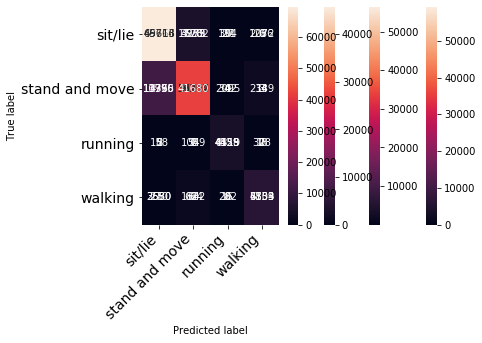

In [28]:
for i in range(len(monitors2)):
    path = monitors2[i]+"_postprocess.csv"
    df = pd.read_csv(path)
    classes = list(df['y_true'].unique())
    cm = confusion_matrix(df['y_true'],df['post_predictions'], classes)
    
    print()
    print_confusion_matrix(cm,classes)
    print()
    print()

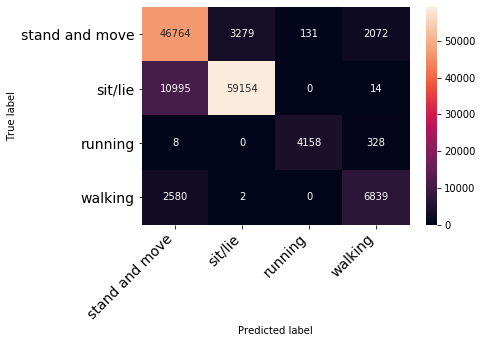

In [27]:
hip_p = pd.read_csv('hip_postprocess.csv')
classes = list(hip_p['y_true'].unique())
cm = confusion_matrix(hip_p['y_true'],hip_p['post_predictions'], classes)
print_confusion_matrix(cm,classes)

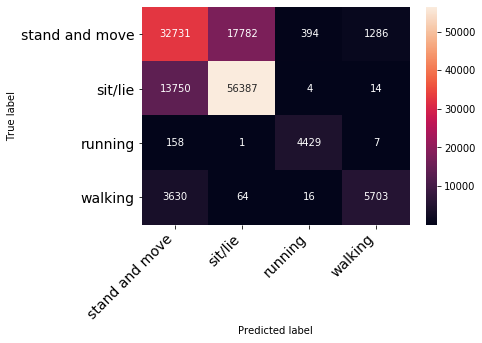

In [29]:
wrist_p = pd.read_csv('wrist_postprocess.csv')
classes = list(wrist_p['y_true'].unique())
cm = confusion_matrix(wrist_p['y_true'],wrist_p['post_predictions'], classes)
print_confusion_matrix(cm,classes)

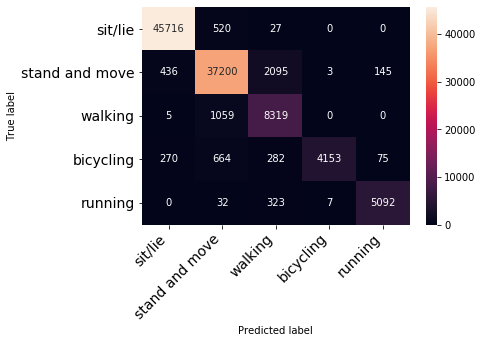

In [31]:
thigh_p = pd.read_csv('thigh_postprocess.csv')
classes = list(thigh_p['y_true'].unique())
cm = confusion_matrix(thigh_p['y_true'],thigh_p['post_predictions'], classes)
print_confusion_matrix(cm,classes)

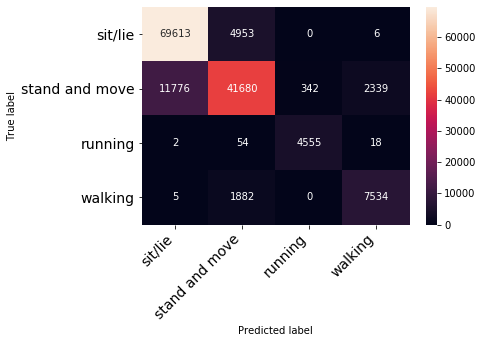

In [32]:
chest_p = pd.read_csv('chest_postprocess.csv')
classes = list(chest_p['y_true'].unique())
cm = confusion_matrix(chest_p['y_true'],chest_p['post_predictions'], classes)
print_confusion_matrix(cm,classes)

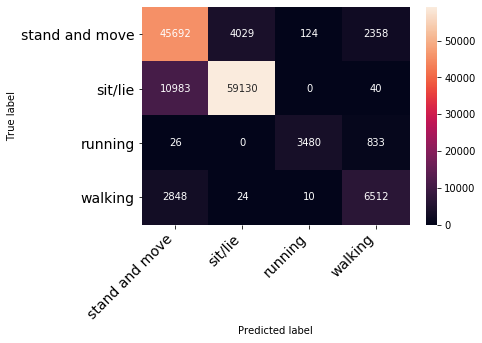

In [33]:
hip_p = pd.read_csv('hip_postprocess.csv')
classes = list(hip_p['y_true'].unique())
cm = confusion_matrix(hip_p['y_true'],hip_p['predicted_values'], classes)
print_confusion_matrix(cm,classes)